<a href="https://colab.research.google.com/github/monicaneli/Transfer-Learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Imagens de Gatos e Cães usando Transfer Learning com VGG16

## Introdução:

O presente projeto tem como objetivo construir um modelo de classificação de imagens capaz de diferenciar entre gatos e cães, utilizando técnicas de Deep Learning e Transfer Learning.

O objetivo final é demonstrar como Transfer Learning pode ser aplicado em problemas reais de classificação de imagens, aproveitando redes profundas pré-treinadas para reduzir tempo de treinamento e melhorar a acurácia mesmo com datasets limitados.


## Dataset utilizado
Para isso, foi empregado o conjunto de dados Cats vs Dogs, disponibilizado pela Microsoft e amplamente utilizado em competições de aprendizado de máquina.

O dataset contém aproximadamente 25 mil imagens divididas em duas classes: “Cat” e “Dog”. Como algumas imagens apresentavam problemas de integridade ou canais não compatíveis, foi realizado um pré-processamento cuidadoso para remover imagens corrompidas e padronizar o formato das imagens para 3 canais RGB e tamanho fixo de 224x224 pixels.

## Redes Neurais Utilizadas

Para acelerar o treinamento e melhorar a performance, foi utilizada a rede pré-treinada VGG16, conhecida por sua robustez em tarefas de visão computacional. Apenas a camada de classificação final foi ajustada para o problema binário específico, enquanto as demais camadas permaneceram congeladas, aproveitando os pesos pré-treinados na ImageNet.


## Particionamento e Pré-processamento
Além disso, o projeto inclui:

- Tamanho do dataset usado para treino/val/test (20% cada) para performance em CPU.

- Normalização de imagens e preprocessamento compatível com VGG16

- Avaliação de acurácia e perda, além de visualização de predições com probabilidades por classe

## Tecnologias utilizadas
O projeto foi desenvolvido em Python utilizando o framework TensorFlow/Keras para construção e treinamento de redes neurais. Para pré-processamento e manipulação de imagens foram empregadas bibliotecas como PIL e NumPy, enquanto Matplotlib foi utilizada para visualização de imagens e métricas de desempenho. Para avaliação de resultados, foram usadas métricas do Scikit-learn (matriz de confusão, recall, F1-score) e JSON para armazenamento dos históricos de treino. Funções padrão de OS e Random foram utilizadas para navegação em diretórios e seleção aleatória de imagens.

## Principais Resultados
A rede CNN simples não foi capaz de generalizar bem, apresentando desempenho próximo ao acaso, enquanto a VGG16 com transfer learning alcançou resultados significativamente superiores, com acurácia de 0.98 e baixíssimos índices de falsos positivos e negativos.


In [4]:
# Imports, parâmetros e funções auxiliares
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image, UnidentifiedImageError

# parâmetros
root = "PetImages"
img_size = (224, 224)
batch_size = 16
seed = 42
valid_exts = (".jpg", ".jpeg", ".png")

# Contar imagens no disco
def count_images_in_dir(root, exts=(".jpg", ".jpeg", ".png")):
  count = 0
  for dp, dn, filenames in os.walk(root):
      for f in filenames:
          if f.lower().endswith(exts):
              count += 1
  return count

def get_image(path, target_size=(224,224)):
  img = image.load_img(path, target_size=target_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return img, x

In [3]:
# Baixando a base de dados cats vs dogs
!echo "Downloading Cats vs Dogs dataset for image notebooks"
!curl -L -o cats_and_dogs.zip --progress-bar https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q cats_and_dogs.zip
!rm cats_and_dogs.zip
!ls


######################################################################## 100.0%
 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'   sample_data


In [3]:
# Removendo imagens corrompidas
for subdir, _, files in os.walk(root):
    for f in files:
        if f.lower().endswith(valid_exts):
            path = os.path.join(subdir, f)
            try:
                img = Image.open(path)
                img = img.convert("RGB")  # força 3 canais
                img.verify()  # checa integridade
                img.save(path)  # salva convertida
            except (UnidentifiedImageError, OSError):
                os.remove(path)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


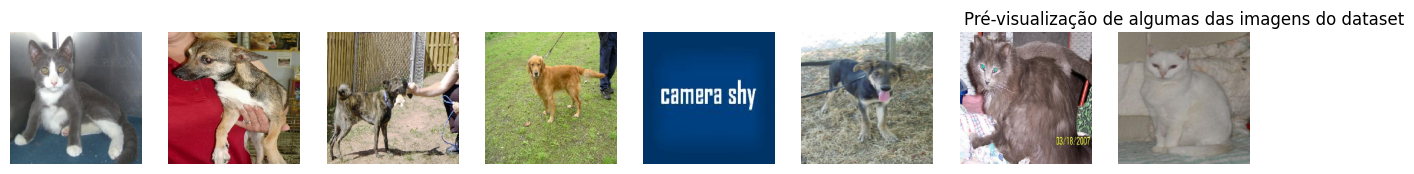

In [4]:
# Amostra das imagens

# Todas as imagens válidas
images = [os.path.join(dp, f)
          for dp, dn, filenames in os.walk(root)
          for f in filenames
          if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

# Escolher 8 imagens aleatórias
idx = random.sample(range(len(images)), 8)
print(f"Indices: {idx}")
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

plt.figure(figsize=(16,4))
for i, img in enumerate(imgs):
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.title("Pré-visualização de algumas das imagens do dataset")
plt.show()

In [5]:
# Dataset e particionamento

# Cria dataset completo e embaralha
full_ds = keras.utils.image_dataset_from_directory(
    root,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

# Parâmetros
class_names = full_ds.class_names
num_classes = len(class_names)

# Conta total de batches
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
print("Total batches no dataset completo:", total_batches)

# Frações de uso (10% de cada split)
train_frac, val_frac, test_frac = 0.1, 0.1, 0.1

# Converte frações para número de batches
train_batches = int(train_frac * total_batches)
val_batches   = int(val_frac * total_batches)
test_batches  = int(test_frac * total_batches)

# Divide usando take / skip
train_ds = full_ds.take(train_batches)
val_ds   = full_ds.skip(train_batches).take(val_batches)
test_ds  = full_ds.skip(train_batches + val_batches).take(test_batches)

# Melhorar performance em CPU
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

# Parâmetro Input Shape: obtido de 1 batch do train_ds
input_shape = None
for images, labels in train_ds.take(1):
    input_shape = images.shape[1:]  # ignora a dimensão do batch

# Conferindo números
print("Total images found in directory:", count_images_in_dir(root))
print("Number of categories:", num_classes)
print("Total batches (dataset completo):", total_batches)
print(f"Usando apenas {train_frac+val_frac+test_frac:.0%} do dataset total")
print("\nTrain batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:  ", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches: ", tf.data.experimental.cardinality(test_ds).numpy())
print("Batch size:", batch_size)
print("Input dimensions:", input_shape)

# Classes
class_names = full_ds.class_names
print("Classes carregadas:", class_names)
print("Classe 0:", class_names[0])
print("Classe 1:", class_names[1])

Found 25000 files belonging to 2 classes.
Total batches no dataset completo: 1563
Total images found in directory: 25000
Number of categories: 2
Total batches (dataset completo): 1563
Usando apenas 30% do dataset total

Train batches: 156
Val batches:   156
Test batches:  156
Batch size: 16
Input dimensions: (224, 224, 3)
Classes carregadas: ['Cat', 'Dog']
Classe 0: Cat
Classe 1: Dog


#### Normalização de imagens
Imagens normalmente vêm com valores de pixel entre 0 e 255 (inteiros, RGB).
Para redes neurais, é recomendável converter para float e escalar para um intervalo menor, o que ajuda o modelo a convergir mais rápido e evita problemas numéricos.

Redes pré-treinadas no Keras (como VGG16, ResNet, Inception) foram treinadas com uma determinada distribuição de valores de pixel.
Se você usar imagens brutas, o modelo não reconhece os padrões corretamente, porque a média e o desvio padrão dos pixels são diferentes do treinamento original.

Para VGG16, a função oficial é:


```
from tensorflow.keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)
```

O que isso faz internamente:

- Converte os pixels para float32 (se ainda não estiver).

- Subtrai a média de cada canal calculada na ImageNet:
[R_mean, G_mean, B_mean] = [123.68, 116.779, 103.939]

- Não divide pelo desvio padrão (VGG16 usa apenas centralização, não padronização completa).

Ou seja, para cada pixel:

```
pixel_R = pixel_R_original - 123.68
pixel_G = pixel_G_original - 116.779
pixel_B = pixel_B_original - 103.939
```

Dessa forma, o input fica compatível com os pesos aprendidos pelo modelo pré-treinado, permitindo que ele extraia features corretamente.

In [6]:
# Normalização
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

### Rede neural baseline

A rede neural baseline construída do zero é uma CNN simples, composta por camadas convolucionais e de pooling para extração de features, seguida de camadas densas que realizam a classificação entre gatos e cães. A camada final utiliza softmax para gerar probabilidades para cada classe, e a rede é treinada com categorical crossentropy e Adam como otimizador.

O objetivo dessa rede é servir como ponto de partida para avaliar a dificuldade do problema e validar o pipeline de pré-processamento, normalização e splits de treino/val/test. Por ser pequena e eficiente, permite testar rapidamente o desempenho inicial.

O modelo baseline é apenas comparativo: serve para avaliar o desempenho de uma rede simples e medir o ganho obtido ao usar a VGG16 pré-treinada, sem influenciar sua arquitetura ou pesos.

In [7]:
# Rede Baseline

# build the network from scratch
model = Sequential()
print("Input dimensions: ",input_shape)

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compilando a rede

# compile the model to use sparse_categorical_crossentropy function and adadelta optimizer
model.compile(
              loss='sparse_categorical_crossentropy',  # aceita labels inteiros
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=(val_ds),
                    epochs=10)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.4970 - loss: 9.4467 - val_accuracy: 0.4940 - val_loss: 0.6942
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.5147 - loss: 0.6921 - val_accuracy: 0.5008 - val_loss: 0.6933
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.5294 - loss: 0.6867 - val_accuracy: 0.5625 - val_loss: 0.6848
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.5273 - loss: 0.6903 - val_accuracy: 0.5048 - val_loss: 0.6955
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.5311 - loss: 0.6878 - val_accuracy: 0.4988 - val_loss: 0.6925
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.4993 - loss: 0.6858 - val_accuracy: 0.5433 - val_loss: 0.6995
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.5546 - loss: 0.6876 - val_accuracy: 0.4864 - val_loss: 0.6972
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.5304 - loss: 0.68

A rede CNN simples apresentou acurácia média de 0,52 no treino, 0,51 na validação e 0,49 no teste, indicando que o modelo não teve desempenho melhor do que uma classificação aleatória.




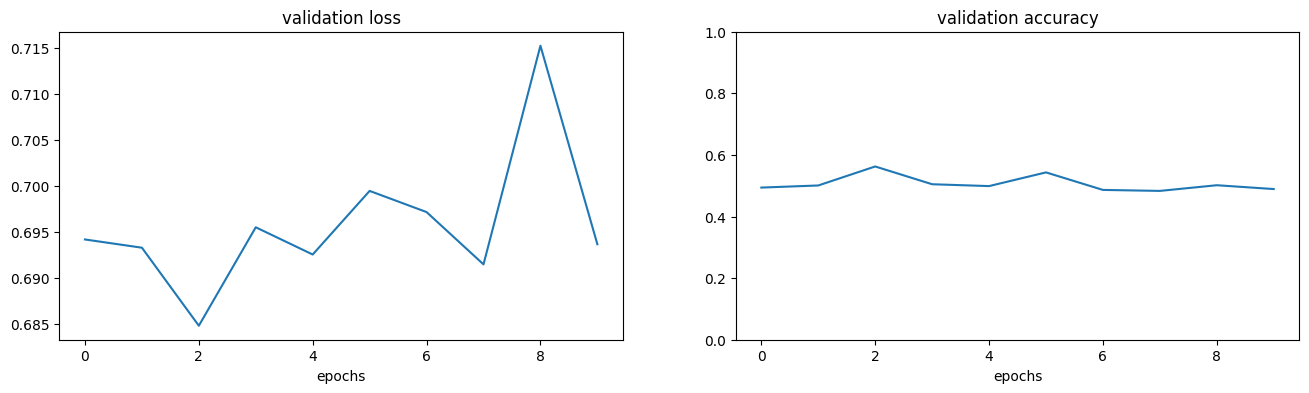

In [9]:
# Avaliação do modelo
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [10]:
# Acurácia de treino e validação registradas em cada época
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# calcular médias
mean_train_acc = np.mean(train_acc)
mean_val_acc = np.mean(val_acc)

print("Acurácia média (treino):", mean_train_acc)
print("Acurácia média (validação):", mean_val_acc)


Acurácia média (treino): 0.5213942289352417
Acurácia média (validação): 0.5064503192901612


In [11]:
# Avaliar no dataset em batches
loss, accuracy = model.evaluate(test_ds, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4801 - loss: 0.6948
Test loss: 0.6932767033576965
Test accuracy: 0.4919871687889099


In [1]:
# Obter predições e labels reais
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", cm)

# Relatório completo: precision, recall, f1-score
print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

NameError: name 'test_ds' is not defined

### Transfer-Learning com a rede VGG16

A rede VGG16 é uma arquitetura de deep convolutional neural network conhecida por sua simplicidade e profundidade, composta por 16 camadas treináveis entre convoluções e fully connected. Ela utiliza pequenos filtros 3x3, intercalados com camadas de max pooling, para extrair gradualmente features cada vez mais complexas das imagens, mantendo a mesma estratégia de padding para preservar dimensões. A rede foi originalmente treinada no ImageNet, contendo milhões de imagens, o que permite que seus pesos pré-treinados capturem padrões visuais genéricos, como bordas, texturas e formas.

No contexto de Transfer Learning, a VGG16 é usada como extrator de features, permitindo adaptar suas representações para novas tarefas com datasets menores. A camada final é substituída por uma camada densa compatível com o número de classes do problema específico, e apenas essas camadas finais são treinadas, enquanto os pesos das camadas convolucionais permanecem congelados. Essa abordagem reduz significativamente o tempo de treinamento e melhora a acurácia, aproveitando o conhecimento prévio da rede sobre padrões visuais.


Nesse projeto, a VGG16 é utilizada como modelo de Transfer Learning para classificar imagens de gatos e cães. O objetivo é aproveitar os pesos pré-treinados da rede para extrair features visuais complexas sem precisar treinar toda a rede do zero, permitindo um treinamento mais rápido e aumentando a precisão na classificação, especialmente considerando o grande volume de imagens e a limitação de recursos computacionais.

In [12]:
# Utilizando uma rede treinada para transfer-learning
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [14]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [15]:
history2 = model_new.fit(train_ds,
                         epochs=10,
                         validation_data=(val_ds))

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 233ms/step - accuracy: 0.9322 - loss: 0.1885 - val_accuracy: 0.9704 - val_loss: 0.1081
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.9892 - loss: 0.0282 - val_accuracy: 0.9720 - val_loss: 0.0985
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.9913 - loss: 0.0217 - val_accuracy: 0.9784 - val_loss: 0.0836
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9784 - val_loss: 0.0840
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9820 - val_loss: 0.0740
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 1.0000 - loss: 8.5191e-04 - val_accuracy: 0.9808 - val_loss: 0.0764
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 1.0000 - loss: 8.5759e-04 - val_accuracy: 0.9804 - val_loss: 0.0818
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 1.0000 -

Já a rede VGG16 com transfer learning a partir dos pesos da base ImageNet obteve acurácia média de 0,994 no treino, 0,978 na validação e 0,985 no teste.

Apenas 15 gatos (1,22%) foram incorretamente classificados como cachorros (falsos positivos) e 20 cachorros (1,58%) foram incorretamente classificados como gatos (falsos negativos). Com esse baixo número de erros, as métricas macro avg e weighted avg alcançaram 0,99, demonstrando que o transfer learning foi altamente eficaz em distinguir gatos e cachorros, mesmo utilizando apenas uma fração do dataset (156 batches, batch size de 16 e 10 épocas).

In [2]:
# Avaliação do modelo e comparações
fig = plt.figure(figsize=(16,4))

# Validation Loss
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Baseline CNN")
ax.plot(history2.history["val_loss"], label="VGG16 (transfer learning)")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Validation Accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Baseline CNN")
ax2.plot(history2.history["val_accuracy"], label="VGG16 (transfer learning)")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

fig.suptitle("Comparação entre CNN Baseline e VGG16 com Transfer Learning", fontsize=14)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [18]:
# Acurácia de treino e validação registradas em cada época
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# calcular médias
mean_train_acc = np.mean(train_acc)
mean_val_acc = np.mean(val_acc)

print("Acurácia média (treino):", mean_train_acc)
print("Acurácia média (validação):", mean_val_acc)


Acurácia média (treino): 0.9945112228393554
Acurácia média (validação): 0.9782051265239715


In [17]:
# Avaliar no dataset de teste
loss, accuracy = model_new.evaluate(test_ds, verbose=1)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9848 - loss: 0.0873
Test loss: 0.0772087424993515
Test accuracy: 0.9855769276618958


In [19]:
# Obter predições e labels reais
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model_new.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:\n", cm)

# Relatório completo: precision, recall, f1-score
print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Matriz de Confusão:
 [[1215   15]
 [  20 1246]]

Relatório de Classificação:

              precision    recall  f1-score   support

         Cat       0.98      0.99      0.99      1230
         Dog       0.99      0.98      0.99      1266

    accuracy                           0.99      2496
   macro avg       0.99      0.99      0.99      2496
weighted avg       0.99      0.99      0.99      2496



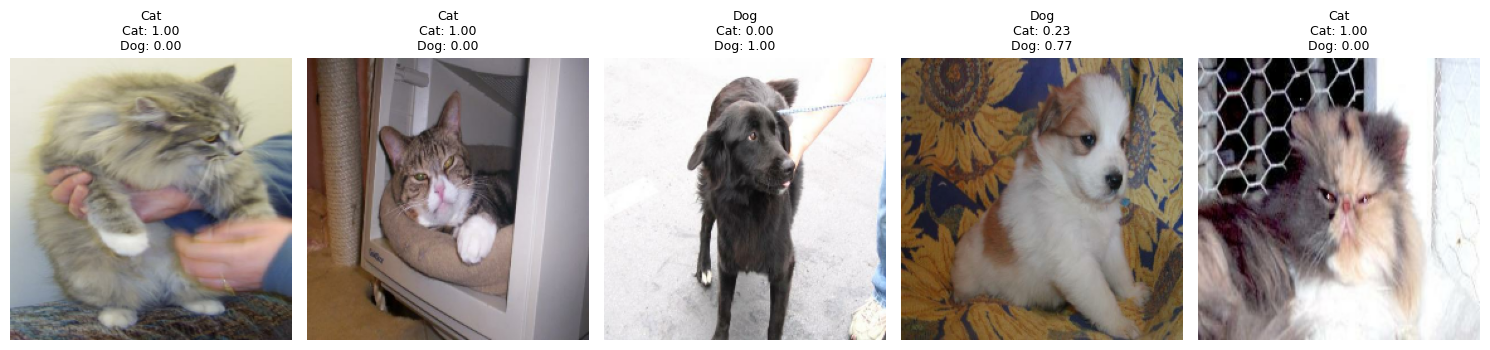

In [30]:
# Plotagem de alguns testes

# Conjunto de imagens não utilizado
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
used_batches = 3* train_batches #train_batches + val_batches + test_batches
remaining_batches = total_batches - used_batches

remaining_ds = full_ds.skip(used_batches).take(remaining_batches)
remaining_ds = remaining_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Pegar algumas imagens do remaining_ds (sem preprocess_input)
sample_ds = remaining_ds.unbatch().take(5)

plt.figure(figsize=(15, 8))

for idx, (img, label) in enumerate(sample_ds, 1):
    # Converter para array numpy para exibir
    img_np = img.numpy().astype("uint8")

    # Preparar para o modelo (com preprocess_input)
    x = np.expand_dims(img_np, axis=0)
    x = preprocess_input(x)

    probabilities = model_new.predict(x, verbose=0)[0]
    pred_class = np.argmax(probabilities)

    prob_text = "\n".join([f"{class_names[i]}: {probabilities[i]:.2f}"
                           for i in range(len(class_names))])

    # Plotar a imagem normal
    plt.subplot(1, 5, idx)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"{class_names[pred_class]}\n{prob_text}", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Salvar modelos no formato .keras
model_baseline.save("model_baseline.keras")
model_new.save("model_vgg16.keras")

print("✅ Modelos salvos: model_baseline.keras, model_vgg16.keras")

# Salvar históricos de treino
# history.history é um dicionário com métricas por epoch
with open("history_baseline.json", "w") as f:
    json.dump(history.history, f)

with open("history_vgg16.json", "w") as f:
    json.dump(history2.history, f)

# Carregar novamente os modelos
#baseline_loaded = keras.models.load_model("model_baseline.keras")
#vgg16_loaded = keras.models.load_model("model_vgg16.keras")

#Carregar histórico salvo
#with open("history_baseline.json", "r") as f:
#    history_baseline = json.load(f)
#print("Histórico baseline (chaves):", history_baseline.keys())


### Resultados

Em resumo, os experimentos demonstraram que a rede CNN simples não foi capaz de generalizar bem, apresentando desempenho próximo ao acaso, enquanto a VGG16 com transfer learning alcançou resultados significativamente superiores, com alta acurácia e baixíssimos índices de falsos positivos e negativos.

Isso evidencia a grande vantagem do uso de modelos pré-treinados, que permitem extrair representações robustas mesmo a partir de um conjunto reduzido de dados, tornando o processo de treinamento mais eficiente e preciso.


## Referências
[1] Trabalho de
kylemath sobre *transfer-learning *[disponível no GitHub](https://github.com/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb).

[2] Bootcamp
BairesDev - Machine Learning Training na DIO